In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from brain_observatory_analysis.behavior.video_qc import annotation_tools
import cv2
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
from pprint import pprint
import h5py
from scipy.spatial import ConvexHull
from matplotlib.path import Path as mplPath

In [2]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)
table.project_code.unique()

array(['VisualBehaviorMultiscope', 'LearningmFISHDevelopment', 'U01BFCT',
       'OpenScopeDendriteCoupling', 'VisualBehavior',
       'VisBIntTestDatacube', 'omFISHGad2Meso', 'VisualBehaviorTask1B',
       'MultiscopeSignalNoise', 'omFISHRbp4Meso', 'LearningmFISHTask1A',
       'TaskTrainedNetworksMultiscope',
       'VisualBehaviorMultiscope4areasx2d', 'omFISHSstMeso',
       'VipAxonalV1Phase1', 'MesoscopeDevelopment', 'omFISHCux2Meso',
       'VisualBehaviorIntegrationTest', 'VisualBehaviorDevelopment'],
      dtype=object)

In [9]:
project_codes = ['VisualBehaviorMultiscope', 'VisualBehaviorMultiscope4areasx2d', 'LearningmFISHTask1A', 'omFISHGad2Meso']
table = table[table.project_code.isin(project_codes)]
last_datetime = datetime(2024, 3, 27, 0, 0, 0)
table = table[table.date_of_acquisition < last_datetime]
len(table.ophys_session_id.unique())

962

In [4]:
table.columns

Index(['equipment_name', 'donor_id', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'foraging_id',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type',
       'experience_level', 'passive', 'image_set'],
      dtype='object')

In [10]:
osids = table.ophys_session_id.unique()
osids[1]

954954402

In [66]:
osids = table.ophys_session_id.unique()
osid = osids[0]
session_dir = from_lims.get_session_h5_filepath(osid).parent
ellipse_filepath = from_lims.get_ellipse_filepath(osid)
eye_tracking_movie = from_lims.get_eye_tracking_avi_filepath(osid)

df = annotation_tools.read_DLC_h5file(from_lims.get_deepcut_h5_filepath(osid))
pupil_likelihood_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='likelihood')].reset_index(drop=True)
pupil_x_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='x')].reset_index(drop=True)
pupil_y_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='y')].reset_index(drop=True)

loaded DLC data


Text(0.5, 1.0, 'osid 952430817')

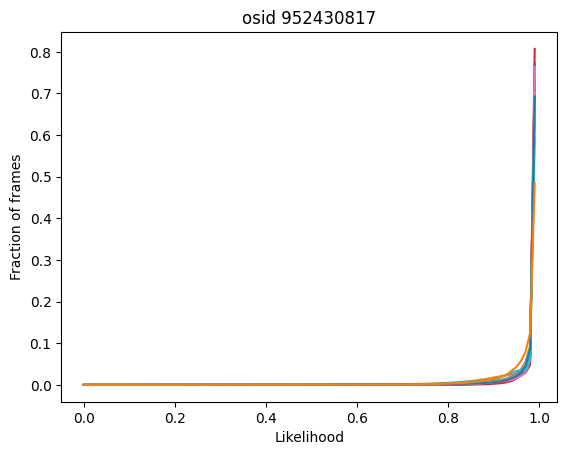

In [67]:
bins = np.linspace(0,1,100)
hist_vals = pupil_likelihood_df.groupby('bodyparts').apply(lambda x: np.histogram(x.value.values, bins=bins)[0]/len(x)).values
fig, ax = plt.subplots()
for i, hist in enumerate(hist_vals):
    ax.plot(bins[:-1], hist, label=pupil_likelihood_df.bodyparts[i])
ax.set_xlabel('Likelihood')
ax.set_ylabel('Fraction of frames')
ax.set_title(f'osid {osid}')

In [109]:
# Takes about 15 minutes

cmap = 'cool'
colors = plt.cm.get_cmap(cmap)(np.linspace(0,1,100))*255
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\qc_pupil'.replace('\\','/'))

cap_eye = cv2.VideoCapture(str(eye_tracking_movie))
width = int(cap_eye.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_eye.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap_eye.get(cv2.CAP_PROP_FPS))
length = int(cap_eye.get(cv2.CAP_PROP_FRAME_COUNT))
assert length == len(pupil_likelihood_df.frame_number.unique())
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
movie_path = save_dir / f'pupil_osid_{osid}.mp4'

out_fps = 5
total_dur = 60 # seconds
out_num_frames = total_dur*out_fps
frame_nums_to_capture = np.linspace(0, length-1, out_num_frames+2).astype(int)[1:-1]
out = cv2.VideoWriter(str(movie_path), fourcc, out_fps, (width, height))

# Define the circle parameters
radius = 1
thickness = 4

for frame_number in frame_nums_to_capture:
    cap_eye.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    ret_eye, frame_eye = cap_eye.read()

    cv2.rectangle(frame_eye, (0,0), (60, 482), (255,255,255), -1)
    for bodyparts in pupil_likelihood_df.bodyparts.unique():
        likelihood = pupil_likelihood_df[(pupil_likelihood_df.bodyparts==bodyparts) &
                                         (pupil_likelihood_df.frame_number==frame_number)].value.values[0]
        color = colors[max(int(np.round(likelihood*100))-1, 0)]
        center_x = int(pupil_x_df[(pupil_x_df.bodyparts==bodyparts) &
                                  (pupil_x_df.frame_number==frame_number)].value.values[0])
        center_y = int(pupil_y_df[(pupil_y_df.bodyparts==bodyparts) &
                                  (pupil_y_df.frame_number==frame_number)].value.values[0])
        cv2.circle(frame_eye, (center_x, center_y), radius, color, thickness)

    out.write(frame_eye)
cap_eye.release()
out.release()



### Run using HPC
- results: \\allen\programs\mindscope\workgroups\learning\qc_pupil

## Some sessions does not have DLC output


In [20]:
# job_records_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\job_records')
job_records_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\qc_pupil\job_records')

# filter by created time, if needed
time_since = datetime(2024, 4, 1, 0, 0, 0)
# from job_dir get files created after time_since
files = [f for f in job_records_dir.glob('**/*') if f.is_file() and f.stat().st_ctime > time_since.timestamp()]

# read and find the ones that failed
failed_files = []
succeeded_osids = []
failed_osids = []
success_word = 'total time ='
for file in files:
    with open(file, 'r') as f:
        lines = f.readlines()
        if np.array([success_word in l for l in lines]).any():
            succeeded_osids.append(int(file.name.split('_')[-1].split('.')[0]))
        else:
            failed_files.append(file)
            failed_osids.append(int(file.name.split('_')[-1].split('.')[0]))
print(len(failed_files))


60


In [22]:
target_osid = failed_osids[0]
fn = [f for f in failed_files if target_osid == int(f.name.split('_')[-1].split('.')[0])][0]
with open(fn, 'r') as f:    
    lines = f.readlines()
pprint(lines)

['==========================================\n',
 'SLURM_JOB_ID = 15552557\n',
 'Username = jinho.kim\n',
 'Group = 10513\n',
 'SLURM_JOB_NODELIST = n108\n',
 '==========================================\n',
 'Traceback (most recent call last):\n',
 '  File '
 '"/home/jinho.kim/anaconda3/envs/allenhpc/lib/python3.8/site-packages/pandas/core/indexes/base.py", '
 'line 3803, in get_loc\n',
 '    return self._engine.get_loc(casted_key)\n',
 '  File "pandas/_libs/index.pyx", line 138, in '
 'pandas._libs.index.IndexEngine.get_loc\n',
 '  File "pandas/_libs/index.pyx", line 165, in '
 'pandas._libs.index.IndexEngine.get_loc\n',
 '  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in '
 'pandas._libs.hashtable.PyObjectHashTable.get_item\n',
 '  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in '
 'pandas._libs.hashtable.PyObjectHashTable.get_item\n',
 "KeyError: 'filepath'\n",
 '\n',
 'The above exception was the direct cause of the following exception:\n',
 '\n',
 'Trac

In [45]:
np.sort(failed_osids)

array([ 839208243,  839514418,  840490733,  841778484,  842023261,
        842364341,  843059122,  844469521,  845235947,  846871218,
        847758278,  848401585,  848983781,  849304162,  850667270,
        850894918,  851740017,  852070825,  853177377,  853416532,
        855711263,  856201876,  863815473,  864458864,  865024413,
        865854762,  866197765,  867027875,  868688430,  870352564,
        870762788,  871526950,  871906231,  873247524,  874070091,
        874616920,  875259383,  875508749,  876303107,  880498009,
        880709154,  881094781,  882386411,  882674040,  882756028,
        883619540,  884451806,  884613038,  885303356,  885557130,
        885653926,  886130638,  886367984,  886806800,  887031077,
        888009781,  888171877,  889042121,  889467038, 1240766002])

In [46]:
# Do they have pupil movie?
osid = np.sort(failed_osids)[-2]
print(from_lims.get_eye_tracking_avi_filepath(osid).parent)

\\allen\programs\braintv\production\visualbehavior\prod0\specimen_837581585\ophys_session_889467038


In [44]:
print(from_lims.get_session_h5_filepath(osid).parent)

\\allen\programs\mindscope\production\learning\prod0\specimen_1222814487\ophys_session_1240766002


In [32]:
osid = succeeded_osids[-1]
print(from_lims.get_eye_tracking_avi_filepath(osid).parent)

\\allen\programs\mindscope\production\learning\prod0\specimen_1321449020\ophys_session_1339313850


In [28]:
from_lims.get_deepcut_h5_filepath(osid)

WindowsPath('//allen/programs/mindscope/production/learning/prod0/specimen_1149593510/ophys_session_1163132450/eye_tracking/1163132450_Eye_20220309T090246DeepCut_resnet50_universal_eye_trackingJul10shuffle1_1030000.h5')

In [29]:
filepath = Path(r'\\allen\programs\braintv\production\neuralcoding\prod0\specimen_810573072\ophys_session_846871218\eye_tracking\846871218_eyetracking_dlc_to_screen_mapping.h5')
df = annotation_tools.read_DLC_h5file(filepath)

KeyError: 'No object named df_with_missing in the file'

In [31]:
with h5py.File(filepath, 'r') as f:
    print(list(f.keys()))

['new_eye_areas', 'new_pupil_areas', 'new_screen_coordinates', 'new_screen_coordinates_spherical', 'raw_eye_areas', 'raw_pupil_areas', 'raw_screen_coordinates', 'raw_screen_coordinates_spherical', 'synced_frame_timestamps', 'version']


## Failed DLC
- One session 1240766002 was failed (16 experiments? No eye video)
- The rest were old ones with different settings of DLC

# Look at the distribution of pixel values
- in the center of the image (2/3 in each dimension)
- calculate from 100 frames

In [137]:
cap_eye = cv2.VideoCapture(str(eye_tracking_movie))
width = int(cap_eye.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_eye.get(cv2.CAP_PROP_FRAME_HEIGHT))
xrange = [int(width/6), int(width/6*5)]
yrange = [int(height/6), int(height/6*5)]
length = int(cap_eye.get(cv2.CAP_PROP_FRAME_COUNT))
frame_nums_to_capture = np.linspace(0, length-1, 102).astype(int)[1:-1]
all_pix_vals = []
for frame_number in frame_nums_to_capture:
    cap_eye.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    ret_eye, frame_eye = cap_eye.read()
    pix_vals = frame_eye[yrange[0]:yrange[1], xrange[0]:xrange[1], 1].flatten()
    all_pix_vals.extend(pix_vals)
cap_eye.release()


In [142]:
np.where(bins%7!=0)[0]

array([  1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,  15,
        16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  29,  30,
        31,  32,  33,  34,  36,  37,  38,  39,  40,  41,  43,  44,  45,
        46,  47,  48,  50,  51,  52,  53,  54,  55,  57,  58,  59,  60,
        61,  62,  64,  65,  66,  67,  68,  69,  71,  72,  73,  74,  75,
        76,  78,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  90,
        92,  93,  94,  95,  96,  97,  99, 100, 101, 102, 103, 104, 106,
       107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121,
       122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 134, 135, 136,
       137, 138, 139, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151,
       152, 153, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166,
       167, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181,
       183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 21

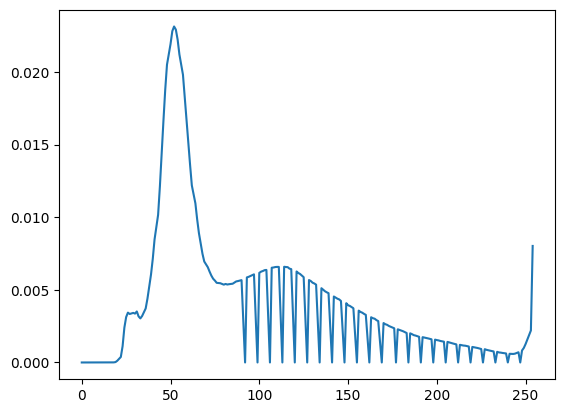

In [144]:
bins = np.arange(0, 256, 1)
hist_vals = np.histogram(all_pix_vals, bins=bins)[0]/len(all_pix_vals)
fig, ax = plt.subplots()
bin_inds = [0, *np.where(bins%7!=0)[0][:-1]]
ax.plot(bins[bin_inds], hist_vals[bin_inds])


In [140]:
np.where(np.histogram(all_pix_vals, bins=bins)[0]==0)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        92,  99, 106, 113, 120, 127, 134, 141, 148, 155, 162, 169, 177,
       184, 191, 198, 205, 212, 219, 226, 233, 240, 247], dtype=int64)

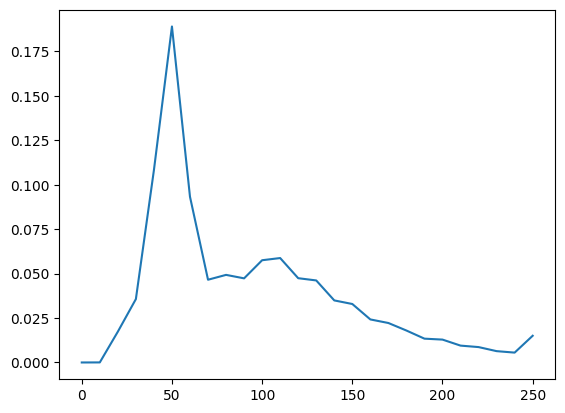

In [146]:
bins = np.arange(0, 256+10, 10)
hist_vals = np.histogram(all_pix_vals, bins=bins)[0]/len(all_pix_vals)
fig, ax = plt.subplots()
ax.plot(bins[:-1], hist_vals)


In [8]:
def get_pix_values(osid):
    eye_tracking_movie = from_lims.get_eye_tracking_avi_filepath(osid)
    cap_eye = cv2.VideoCapture(str(eye_tracking_movie))
    width = int(cap_eye.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_eye.get(cv2.CAP_PROP_FRAME_HEIGHT))
    xrange = [int(width/6), int(width/6*5)]
    yrange = [int(height/6), int(height/6*5)]
    length = int(cap_eye.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_nums_to_capture = np.linspace(0, length-1, 102).astype(int)[1:-1]
    all_pix_vals = []
    for frame_number in frame_nums_to_capture:
        cap_eye.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
        _, frame_eye = cap_eye.read()
        pix_vals = frame_eye[yrange[0]:yrange[1], xrange[0]:xrange[1], 1].flatten()
        all_pix_vals.extend(pix_vals)
    cap_eye.release()
    return all_pix_vals



In [ ]:
# It will take longer than 4 hours to run
pix_val_save_dir = save_dir / 'pix_vals'
pix_val_save_dir.mkdir(exist_ok=True)

all_pix_vals = []
pix_hist = []
osid_run = []
for osid in tqdm(osids):
    try:
        temp_apv = get_pix_values(osid)
        all_pix_vals.append(temp_apv)
        save_fn = pix_val_save_dir / f'pix_vals_osid_{osid}.npy'
        np.save(save_fn, temp_apv)
        bins = np.arange(0, 256, 1)
        hist_vals = np.histogram(temp_apv, bins=bins)[0]/len(temp_apv)
        pix_hist.append(hist_vals)
        osid_run.append(osid)
    except:
        print(f'Error in osid {osid}')
        continue

results = {'osid': osid_run, 'pix_hist': pix_hist}
save_fn = save_dir / 'pix_vals/pix_hist_results.npy'
np.save(save_fn, results)



## DLC output histogram

In [48]:
def get_dlc_likelihood_histogram(osid, bins = np.linspace(0,1,100)):
    df = annotation_tools.read_DLC_h5file(from_lims.get_deepcut_h5_filepath(osid))
    pupil_likelihood_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='likelihood')].reset_index(drop=True)
    hist_vals = pupil_likelihood_df.groupby('bodyparts').apply(lambda x: np.histogram(x.value.values, bins=bins)[0]/len(x)).values
    return hist_vals, bins

In [15]:
osid = osids[0]
df = annotation_tools.read_DLC_h5file(from_lims.get_deepcut_h5_filepath(osid))
pupil_likelihood_df = df[df.bodyparts.str.contains('pupil') & (df.coords=='likelihood')].reset_index(drop=True)


loaded DLC data


In [49]:
osid = osids[0]
hist_vals, bins = get_dlc_likelihood_histogram(osid)

loaded DLC data


In [ ]:
# Took 233 min to run them all

dlc_likelihood_dir = save_dir / 'dlc_likelihood'
dlc_likelihood_dir.mkdir(exist_ok=True)
for osid in np.sort(osids):
    try:
        hist_vals, bins = get_dlc_likelihood_histogram(osid)
        save_fn = dlc_likelihood_dir / f'dlc_likelihood_osid_{osid}.npy'
        np.save(save_fn, hist_vals)
    except:
        print(f'Error in osid {osid}')
        continue

In [54]:
error_osids = []
for osid in np.sort(osids):
    load_fn = dlc_likelihood_dir / f'dlc_likelihood_osid_{osid}.npy'
    if not load_fn.exists():
        error_osids.append(osid)

In [56]:
len(error_osids) # same as the ones failed in movie saving

60

In [58]:
succeeded_osids = np.setdiff1d(np.sort(osids), error_osids)
osid = succeeded_osids[0]
load_fn = dlc_likelihood_dir / f'dlc_likelihood_osid_{osid}.npy'
hist_vals = np.load(load_fn, allow_pickle=True)

Text(0.5, 1.0, 'osid 841303580')

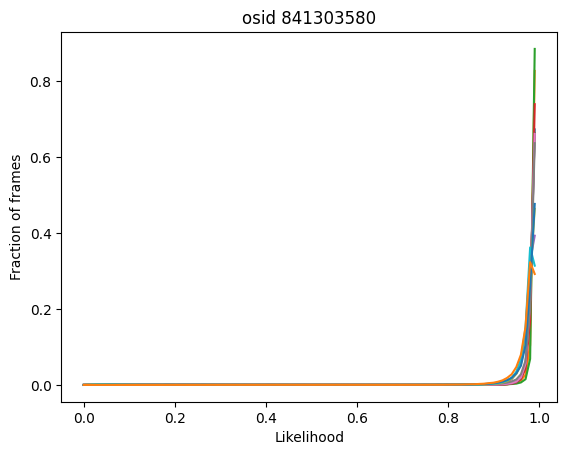

In [61]:
fig, ax = plt.subplots()
for val in hist_vals:
    ax.plot(bins[:-1], val)
ax.set_xlabel('Likelihood')
ax.set_ylabel('Fraction of frames')
ax.set_title(f'osid {osid}')

In [62]:
hist_vals_all = []
for osid in succeeded_osids:
    load_fn = dlc_likelihood_dir / f'dlc_likelihood_osid_{osid}.npy'
    hist_vals = np.load(load_fn, allow_pickle=True)
    hist_vals_all.append(hist_vals)

Text(0.5, 1.0, 'All traces from all the sessions')

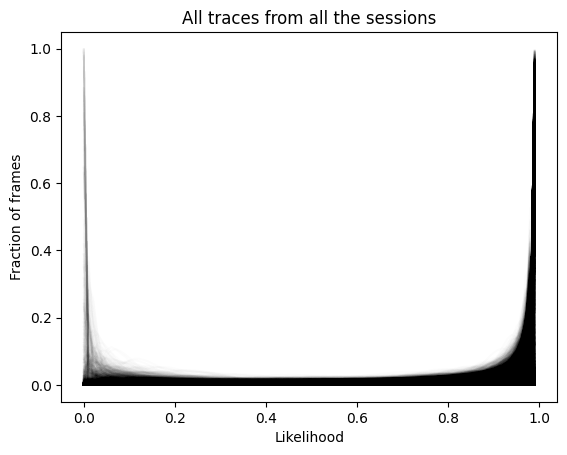

In [69]:
fig, ax = plt.subplots()
for vals in hist_vals_all:
    for val in vals:
        ax.plot(bins[:-1], val, 'k', alpha=0.01)
ax.set_xlabel('Likelihood')
ax.set_ylabel('Fraction of frames')
ax.set_title(f'All traces from all the sessions')

(0.0, 0.2)

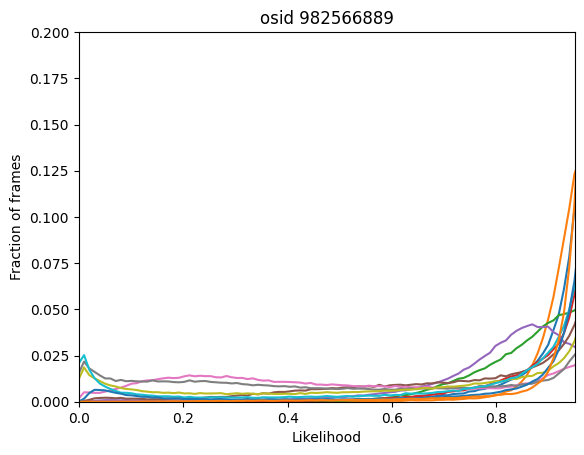

In [84]:
# osid = 982566889
osid = 982566889
load_fn = dlc_likelihood_dir / f'dlc_likelihood_osid_{osid}.npy'
hist_vals = np.load(load_fn, allow_pickle=True)
fig, ax = plt.subplots()
for val in hist_vals:
    ax.plot(bins[:-1], val)
ax.set_xlabel('Likelihood')
ax.set_ylabel('Fraction of frames')
ax.set_title(f'osid {osid}')
ax.set_xlim([0, 0.95])
ax.set_ylim([0, 0.2])

## Check if all pupil points are within the convex hull of eye points

In [86]:
filepath = from_lims.get_deepcut_h5_filepath(osid)
df = annotation_tools.read_DLC_h5file(filepath)

loaded DLC data


In [90]:
df.bodyparts.unique()

array(['cr1', 'cr2', 'cr3', 'cr4', 'cr5', 'cr6', 'cr7', 'cr8', 'cr9',
       'cr10', 'cr11', 'cr12', 'eye1', 'eye2', 'eye3', 'eye4', 'eye5',
       'eye6', 'eye7', 'eye8', 'eye9', 'eye10', 'eye11', 'eye12',
       'pupil1', 'pupil2', 'pupil3', 'pupil4', 'pupil5', 'pupil6',
       'pupil7', 'pupil8', 'pupil9', 'pupil10', 'pupil11', 'pupil12'],
      dtype=object)

In [97]:
df.columns

Index(['bodyparts', 'coords', 'frame_number', 'value'], dtype='object')

In [99]:
df[df.frame_number==100].apply(lambda x: x.value if (x.coords == 'x') and )

,bodyparts,coords,frame_number,value
100,cr1,x,100,359.474846
136236,cr1,y,100,292.248277
272372,cr1,likelihood,100,0.966519
408508,cr2,x,100,359.259949
544644,cr2,y,100,296.427078
...,...,...,...,...
14022108,pupil11,y,100,209.505851
14158244,pupil11,likelihood,100,0.960287
14294380,pupil12,x,100,416.380164
14430516,pupil12,y,100,216.780270


In [98]:
df[(df.bodyparts.str.contains('pupil')) & ((df.coords=='x') | (df.coords=='y')) & (df.frame_number==100)]

,bodyparts,coords,frame_number,value
9801892,pupil1,x,100,431.879766
9938028,pupil1,y,100,238.398129
10210300,pupil2,x,100,437.189143
10346436,pupil2,y,100,269.663077
10618708,pupil3,x,100,417.372088
10754844,pupil3,y,100,335.093864
11027116,pupil4,x,100,398.839577
11163252,pupil4,y,100,357.543428
11435524,pupil5,x,100,352.197606
11571660,pupil5,y,100,375.303398


In [100]:
pupil_df = df[(df.bodyparts.str.contains('pupil')) & ((df.coords=='x') | (df.coords=='y')) & (df.frame_number==100)]
pupil_bodyparts = pupil_df.bodyparts.unique()
x_vals = []
y_vals = []
for bp in pupil_bodyparts:
    x_val = pupil_df[(pupil_df.bodyparts==bp) & (pupil_df.coords=='x')].value.values[0]
    y_val = pupil_df[(pupil_df.bodyparts==bp) & (pupil_df.coords=='y')].value.values[0]
    x_vals.append(x_val)
    y_vals.append(y_val)
    

In [110]:
hull = ConvexHull(pupil_points)

array([[431.87976551, 238.39812899],
       [386.05338788, 210.97003853],
       [402.05267727, 209.50585079],
       [416.38016415, 216.78026962],
       [437.1891433 , 269.66307688],
       [417.37208843, 335.09386396],
       [398.8395772 , 357.54342771],
       [352.19760609, 375.30339789],
       [326.51295471, 379.68889481],
       [304.33082128, 361.1254518 ],
       [289.29501724, 199.18979096],
       [372.29396731, 214.77147245]])

In [118]:
# eye_df = df[(df.bodyparts.str.contains('eye')) & ((df.coords=='x') | (df.coords=='y')) & (df.frame_number==100)]
# eye_points = np.stack(eye_df.groupby('bodyparts').apply(lambda x: np.array([x[x['coords']=='x'].value.values[0], x[x['coords']=='y'].value.values[0]])).values)
# hull = ConvexHull(eye_points)
# hull_path = mplPath(eye_points[hull.vertices])
# pupil_points = np.stack(pupil_df.groupby('bodyparts').apply(lambda x: np.array([x[x['coords']=='x'].value.values[0], x[x['coords']=='y'].value.values[0]])).values)
inside=0
for pupil_point in pupil_points:
    inside += hull_path.contains_point(pupil_point)
inside/len(pupil_points)

1.0

In [120]:
def _get_pupil_inside_ratio(df):
    eye_df = df[(df.bodyparts.str.contains('eye')) & ((df.coords=='x') | (df.coords=='y'))]
    eye_points = np.stack(eye_df.groupby('bodyparts').apply(lambda x: np.array([x[x['coords']=='x'].value.values[0], x[x['coords']=='y'].value.values[0]])).values)
    hull = ConvexHull(eye_points)
    hull_path = mplPath(eye_points[hull.vertices])
    pupil_points = np.stack(pupil_df.groupby('bodyparts').apply(lambda x: np.array([x[x['coords']=='x'].value.values[0], x[x['coords']=='y'].value.values[0]])).values)
    inside=0
    for pupil_point in pupil_points:
        inside += hull_path.contains_point(pupil_point)
    return inside/len(pupil_points)



frame_number
0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
136131    1.0
136132    1.0
136133    1.0
136134    1.0
136135    1.0
Length: 136136, dtype: float64

In [ ]:
df.groupby('frame_number').apply(_get_pupil_inside_ratio)
# takes about 45 min for 136k frames (one session)

## Run pupil being inside of eye points in HPC